In [1]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import numpy as np
import pandas as pd
import plotly
import plotly.graph_objects as go
import scipy.sparse
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from PIL import Image
from sklearn.metrics import plot_roc_curve, auc
from sklearn.model_selection import StratifiedKFold
import nltk
import string
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer

In [2]:
df = pd.read_csv('spam.csv', encoding = 'latin-1', usecols = ['v1', 'v2'])
df = df.dropna(how = "any", axis = 1)
df.columns = ['target', 'message']

df.head()

target                                            message
0    ham  Go until jurong point, crazy.. Available only ...
1    ham                      Ok lar... Joking wif u oni...
2   spam  Free entry in 2 a wkly comp to win FA Cup fina...
3    ham  U dun say so early hor... U c already then say...
4    ham  Nah I don't think he goes to usf, he lives aro...

In [3]:
df['message_ln'] = df['message'].apply(lambda x: len(x.split(' ')))
df.head()

target                                            message  message_ln
0    ham  Go until jurong point, crazy.. Available only ...          20
1    ham                      Ok lar... Joking wif u oni...           6
2   spam  Free entry in 2 a wkly comp to win FA Cup fina...          28
3    ham  U dun say so early hor... U c already then say...          11
4    ham  Nah I don't think he goes to usf, he lives aro...          13

In [4]:
# Max possible ln
max(df['message_ln'])

171

In [5]:
# EDA


In [6]:
pd.set_option('display.max_columns', 500)
df.head()

target                                            message  message_ln
0    ham  Go until jurong point, crazy.. Available only ...          20
1    ham                      Ok lar... Joking wif u oni...           6
2   spam  Free entry in 2 a wkly comp to win FA Cup fina...          28
3    ham  U dun say so early hor... U c already then say...          11
4    ham  Nah I don't think he goes to usf, he lives aro...          13

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   target      5572 non-null   object
 1   message     5572 non-null   object
 2   message_ln  5572 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 130.7+ KB


In [8]:
df.shape

(5572, 3)

In [9]:
df.duplicated().sum()

403

In [10]:
df.isnull().sum()

target        0
message       0
message_ln    0
dtype: int64

In [11]:
# Is it balanced ? 

In [12]:
balance_counts = df.groupby('target')['target'].agg('count').values
balance_counts

array([4825,  747], dtype=int64)

In [13]:
# Calculate the counts and percentages of each class
label_counts = df['target'].value_counts()
ham_count = label_counts['ham']
spam_count = label_counts['spam']
total_messages = ham_count + spam_count
ham_percentage = (ham_count / total_messages) * 100
spam_percentage = (spam_count / total_messages) * 100

print(f"Ham messages: {ham_count} ({ham_percentage:.2f}%)")
print(f"Spam messages: {spam_count} ({spam_percentage:.2f}%)")

# Define colors for visualization
color_ham = '#1f77b4'   # Blue for 'ham'
color_spam = '#ff7f0e'  # Orange for 'spam'

# Create the bar chart
fig = go.Figure()

fig.add_trace(go.Bar(
    x=['Ham'],
    y=[ham_count],
    name='Ham',
    text=[f'{ham_count} messages<br>{ham_percentage:.2f}%'],
    textposition='auto',
    marker_color=color_ham
))

fig.add_trace(go.Bar(
    x=['Spam'],
    y=[spam_count],
    name='Spam',
    text=[f'{spam_count} messages<br>{spam_percentage:.2f}%'],
    textposition='auto',
    marker_color=color_spam
))

# Update the layout
fig.update_layout(
    title={
        'text': 'Dataset Distribution by Target',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {'size': 24, 'family': 'Times New Roman'}
    },
    xaxis_title='Message Type',
    yaxis_title='Number of Messages',
    bargap=0.5,
    showlegend=False,
    template='simple_white'
)

fig.show()

Ham messages: 4825 (86.59%)
Spam messages: 747 (13.41%)


In [14]:
import plotly.express as px

# Prepare data
labels = ['Ham', 'Spam']
counts = [ham_count, spam_count]

# Create the pie chart
fig_pie = px.pie(
    names=labels,
    values=counts,
    color=labels,
    color_discrete_map={'Ham': color_ham, 'Spam': color_spam},
    title='Proportion of Ham vs. Spam Messages',
    hole=0.4  # Creates a donut chart
)

# Update layout
fig_pie.update_traces(
    textposition='inside',
    textinfo='percent+label'
)

fig_pie.update_layout(
    title={
        'text': 'Proportion of Ham vs. Spam Messages',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {'size': 24, 'family': 'Times New Roman'}
    },
    showlegend=False
)

fig_pie.show()


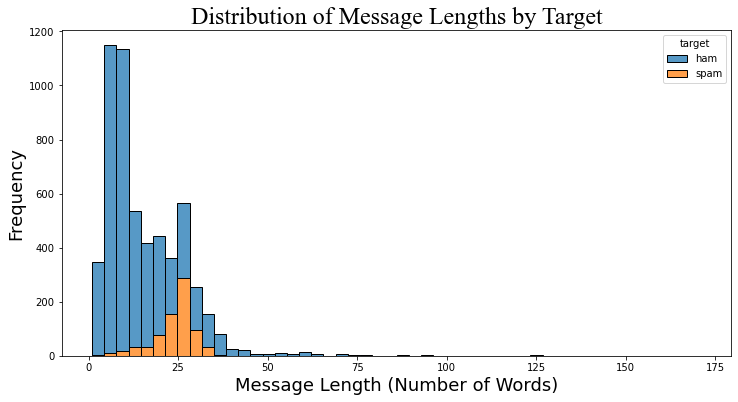

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the distribution of message lengths by target
plt.figure(figsize=(12,6))
sns.histplot(data=df, x='message_ln', hue='target', multiple='stack', bins=50, palette=[color_ham, color_spam])
plt.title('Distribution of Message Lengths by Target', fontsize=24, fontfamily='Times New Roman')
plt.xlabel('Message Length (Number of Words)', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.show()


In [15]:
classes = df.groupby('target').count()
classes['message']

target
ham     4825
spam     747
Name: message, dtype: int64

In [16]:
df['target'] = df['target'].map({'spam' : 1, 'ham' : 0}) # encoding

In [17]:
df.drop_duplicates(keep = 'first', inplace = True)
df.shape

(5169, 3)

In [18]:
df.head()

target                                            message  message_ln
0       0  Go until jurong point, crazy.. Available only ...          20
1       0                      Ok lar... Joking wif u oni...           6
2       1  Free entry in 2 a wkly comp to win FA Cup fina...          28
3       0  U dun say so early hor... U c already then say...          11
4       0  Nah I don't think he goes to usf, he lives aro...          13

In [19]:
df_bow = df.copy()

0    4516
1     653
Name: target, dtype: int64


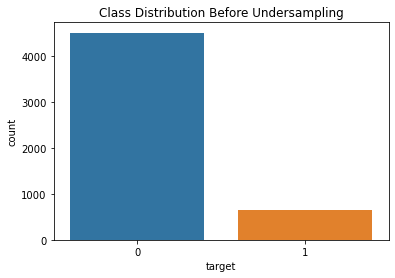

In [20]:
# Handling Imbalance using undersampling and EDA2
# Check the class distribution
print(df['target'].value_counts())

# Visualize the class distribution
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='target', data=df)
plt.title('Class Distribution Before Undersampling')
plt.show()


In [21]:
# Calculate number of characters and words
df['num_chars'] = df['message'].str.len()
df['num_words'] = df['message'].str.split().apply(len)


Original class distribution:
0    4516
1     653
Name: target, dtype: int64

Class distribution after undersampling:
0    1451
1     653
Name: target, dtype: int64


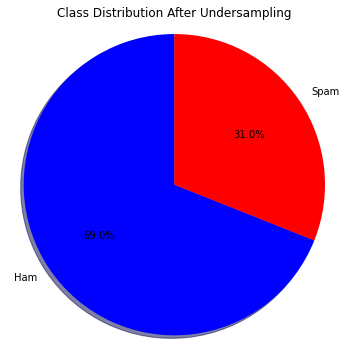

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Check the original class distribution
print("Original class distribution:")
print(df['target'].value_counts())

# Step 2: Separate majority and minority classes
df_ham = df[df['target'] == 0]   # Majority class ('Ham')
df_spam = df[df['target'] == 1]  # Minority class ('Spam')

# Step 3: Define the desired sampling ratio
desired_ratio = 0.45  # For example, minority class will be 50% of the majority class

# Calculate the number of majority samples needed
num_minority = len(df_spam)
num_majority = int(num_minority / desired_ratio)

# Ensure we don't sample more than available
num_majority = min(num_majority, len(df_ham))

# Step 4: Undersample the majority class
df_ham_under = df_ham.sample(n=num_majority, random_state=42)

# Step 5: Combine minority class with undersampled majority class
df_under = pd.concat([df_ham_under, df_spam], axis=0)

# Step 6: Shuffle the dataset
df_under = df_under.sample(frac=1, random_state=42).reset_index(drop=True)

# Step 7: Verify the new class distribution
print("\nClass distribution after undersampling:")
print(df_under['target'].value_counts())

# Step 8: Visualize the class distribution
class_counts = df_under['target'].value_counts()
labels = ['Ham', 'Spam']
colors = ['blue', 'red']

plt.figure(figsize=(6,6))
plt.pie(
    class_counts,
    labels=labels,
    colors=colors,
    autopct='%1.1f%%',
    shadow=True,
    startangle=90
)
plt.title('Class Distribution After Undersampling')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


In [60]:
# Now Data is kinda balanced as nearly 70, 30 ratio is acceptable in fraud detection domain.

# EDA2

In [29]:
# Calculate the number of characters and words in each message
df_under['num_chars'] = df_under['message'].apply(len)
df_under['num_words'] = df_under['message'].apply(lambda x: len(x.split()))

In [28]:
# Descriptive statistics
desc_stats = df_under[['num_chars', 'num_words']].describe().round()
print(desc_stats)

       num_chars  num_words
count     2104.0     2104.0
mean        91.0       17.0
std         58.0       11.0
min          2.0        1.0
25%         39.0        8.0
50%         78.0       15.0
75%        143.0       25.0
max        588.0      125.0


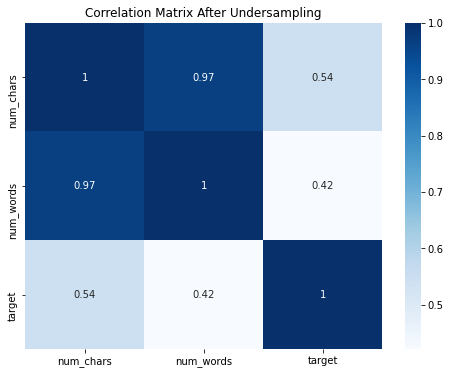

In [30]:
# Calculate the correlation matrix
corr_matrix = df_under[['num_chars', 'num_words', 'target']].corr()

# Plot the correlation matrix
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='Blues')
plt.title('Correlation Matrix After Undersampling')
plt.show()

In [31]:
# Map target labels
df_under['target_label'] = df_under['target'].map({0: 'HAM', 1: 'SPAM'})


             num_chars          num_words         
                  mean min  max      mean min  max
target_label                                      
HAM               69.0   2  588      14.0   1  125
SPAM             138.0  13  224      24.0   2   35


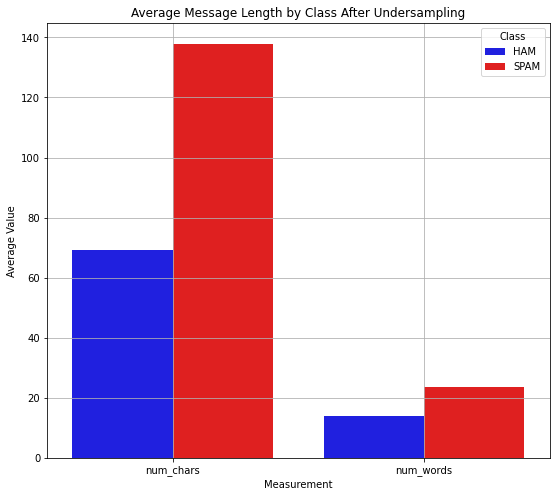

In [32]:
# Grouped statistics
grouped_stats = df_under.groupby('target_label')[['num_chars', 'num_words']].agg(['mean', 'min', 'max']).round()
print(grouped_stats)

# Calculate average values
avg_values = df_under.groupby('target_label')[['num_chars', 'num_words']].mean().reset_index()

# Melt the DataFrame for plotting
avg_melted = avg_values.melt(id_vars='target_label', value_vars=['num_chars', 'num_words'],
                             var_name='Measurement', value_name='Average')

# Define colors for the classes
colors = ['blue', 'red']

# Plot average message lengths
plt.figure(figsize=(9, 8))
sns.barplot(x='Measurement', y='Average', hue='target_label', data=avg_melted, palette=colors)
plt.title('Average Message Length by Class After Undersampling')
plt.xlabel('Measurement')
plt.ylabel('Average Value')
plt.legend(title='Class')
plt.grid(True)
plt.show()


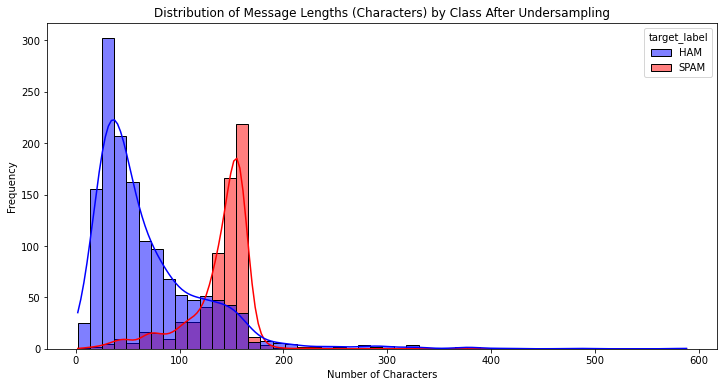

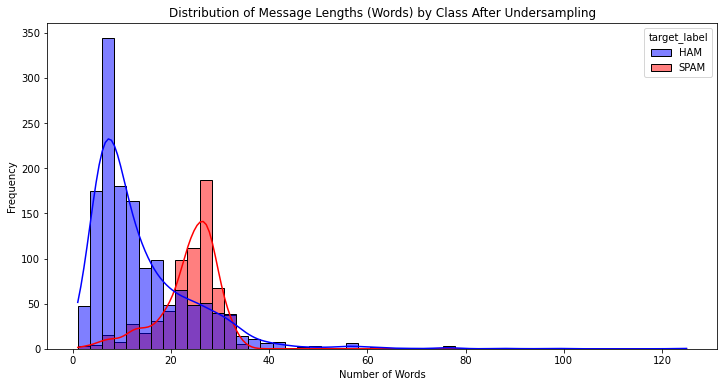

In [33]:
# Histogram of number of characters
plt.figure(figsize=(12, 6))
sns.histplot(data=df_under, x='num_chars', hue='target_label', bins=50, palette=colors, kde=True)
plt.title('Distribution of Message Lengths (Characters) by Class After Undersampling')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.show()

# Histogram of number of words
plt.figure(figsize=(12, 6))
sns.histplot(data=df_under, x='num_words', hue='target_label', bins=50, palette=colors, kde=True)
plt.title('Distribution of Message Lengths (Words) by Class After Undersampling')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()


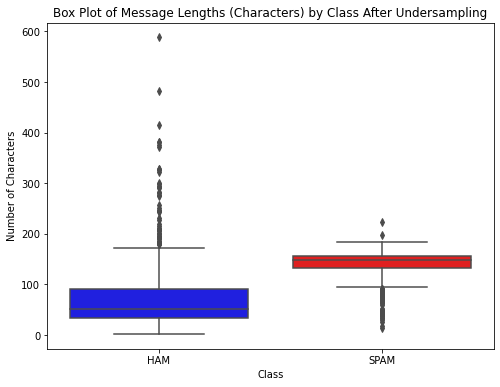

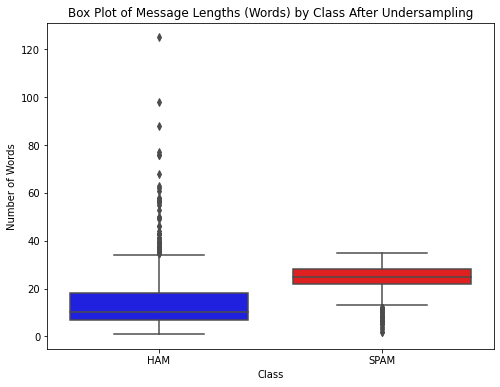

In [34]:
# Box plot of number of characters
plt.figure(figsize=(8, 6))
sns.boxplot(x='target_label', y='num_chars', data=df_under, palette=colors)
plt.title('Box Plot of Message Lengths (Characters) by Class After Undersampling')
plt.xlabel('Class')
plt.ylabel('Number of Characters')
plt.show()

# Box plot of number of words
plt.figure(figsize=(8, 6))
sns.boxplot(x='target_label', y='num_words', data=df_under, palette=colors)
plt.title('Box Plot of Message Lengths (Words) by Class After Undersampling')
plt.xlabel('Class')
plt.ylabel('Number of Words')
plt.show()


In [67]:
'''

Observations and Insights

    Spam Messages Are Longer in both chars and words:
        Average Lengths: Spam messages have higher average numbers of characters and words compared to ham messages.
        Visual Evidence: Bar plots, histograms, and box plots confirm that spam messages tend to be longer.
    Distribution Patterns:
        Histograms show that spam messages have a wider distribution towards higher lengths.
        Ham messages are more concentrated in shorter lengths.
    Correlation:
        The correlation matrix indicates a relationship between message lengths and the target variable.
        Message length features may be useful for classification.
'''

'\n\nObservations and Insights\n\n    Spam Messages Are Longer in both chars and words:\n        Average Lengths: Spam messages have higher average numbers of characters and words compared to ham messages.\n        Visual Evidence: Bar plots, histograms, and box plots confirm that spam messages tend to be longer.\n    Distribution Patterns:\n        Histograms show that spam messages have a wider distribution towards higher lengths.\n        Ham messages are more concentrated in shorter lengths.\n    Correlation:\n        The correlation matrix indicates a relationship between message lengths and the target variable.\n        Message length features may be useful for classification.\n'

In [37]:
# Preprocessing and Corpus cleaning
def clean_text(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words += more_stopwords

def remove_stopwords(text):
    return ' '.join(word for word in text.split() if word not in stop_words)

stemmer = nltk.SnowballStemmer("english")

def stem_text(text):
    return ' '.join(stemmer.stem(word) for word in text.split())

def preprocess_data(text):
    text = clean_text(text)
    text = remove_stopwords(text)
    text = stem_text(text)
    return text

In [38]:
# Apply preprocessing to the 'message' column
df_under['message_clean'] = df_under['message'].apply(preprocess_data)


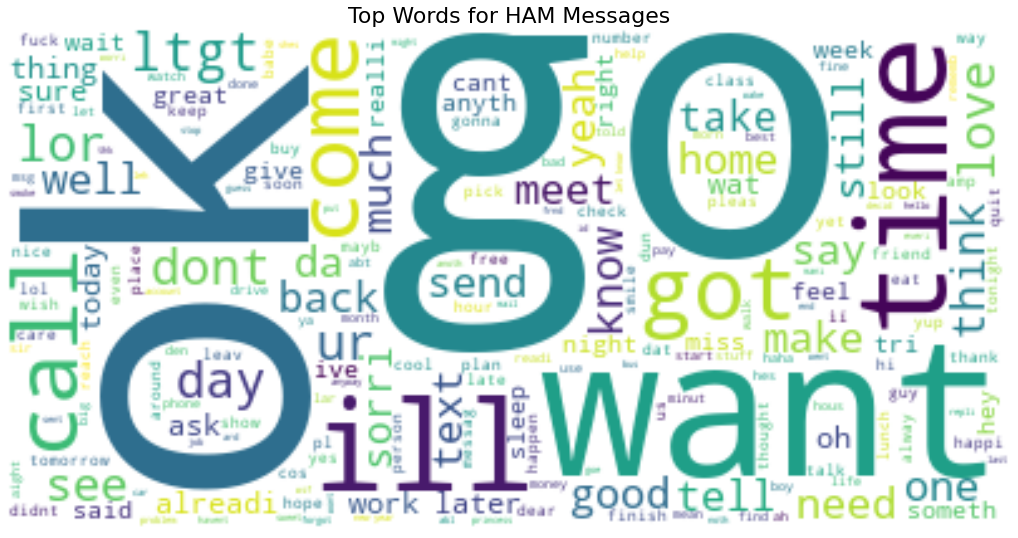

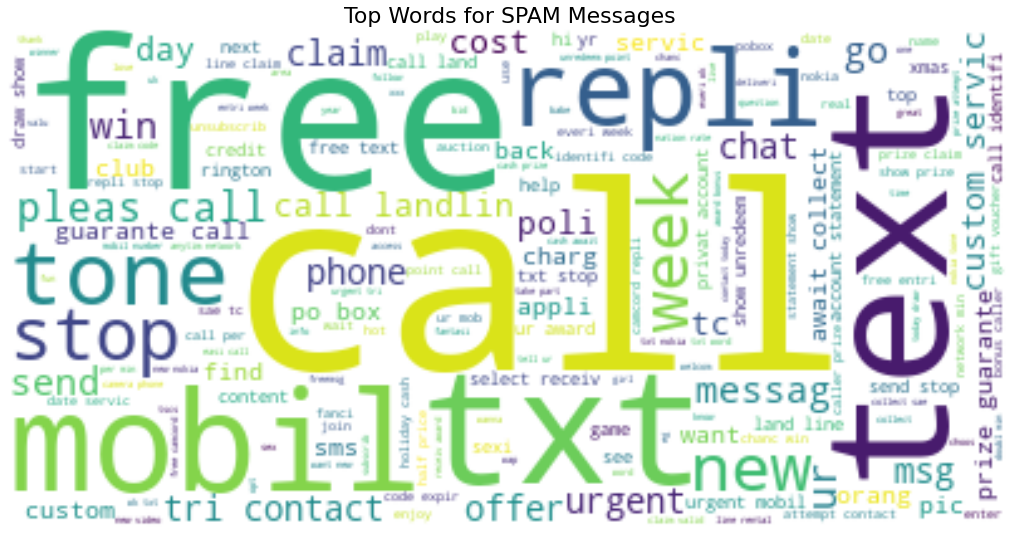

In [40]:
# Word clouds Generation
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Word cloud for 'HAM' messages
ham_text = ' '.join(df_under[df_under['target'] == 0]['message_clean'])
wc_ham = WordCloud(background_color='white', max_words=200).generate(ham_text)

plt.figure(figsize=(18,10))
plt.title('Top Words for HAM Messages', fontdict={'size': 22})
plt.imshow(wc_ham, interpolation='bilinear')
plt.axis('off')
plt.show()

# Word cloud for 'SPAM' messages
spam_text = ' '.join(df_under[df_under['target'] == 1]['message_clean'])
wc_spam = WordCloud(background_color='white', max_words=200).generate(spam_text)

plt.figure(figsize=(18,10))
plt.title('Top Words for SPAM Messages', fontdict={'size': 22})
plt.imshow(wc_spam, interpolation='bilinear')
plt.axis('off')
plt.show()

In [41]:
X = df_under['message_clean']
y = df_under['target']

# First split: 80% train_val, 20% test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Second split: 75% train, 25% validation (of the 80% train_val set)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val
)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Training set size: 1262
Validation set size: 421
Test set size: 421


In [42]:
# Vectorization

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the vectorizer
vectorizer = TfidfVectorizer(max_features=5000)

# Fit the vectorizer on the training data
vectorizer.fit(X_train)

# Transform the datasets
X_train_vect = vectorizer.transform(X_train)
X_val_vect = vectorizer.transform(X_val)
X_test_vect = vectorizer.transform(X_test)


In [46]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

model = MultinomialNB()

# Train 
model.fit(X_train_vect, y_train)

# Predict on the validation set
y_val_pred = model.predict(X_val_vect)
y_val_proba = model.predict_proba(X_val_vect)[:, 1]

# Evaluate t
print("Validation Set Performance Before Cross-Validation:")
print(classification_report(y_val, y_val_pred))


Validation Set Performance Before Cross-Validation:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       290
           1       0.96      0.90      0.93       131

    accuracy                           0.96       421
   macro avg       0.96      0.94      0.95       421
weighted avg       0.96      0.96      0.96       421



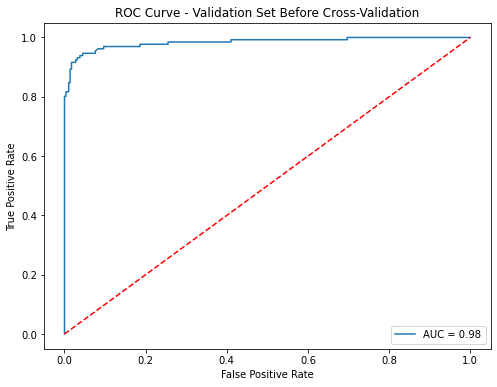

In [47]:
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area for validation set
fpr, tpr, thresholds = roc_curve(y_val, y_val_proba)
roc_auc = roc_auc_score(y_val, y_val_proba)

# Plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1], [0,1], 'r--')
plt.title('ROC Curve - Validation Set Before Cross-Validation')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


In [48]:
# Do cross validation
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(model, X_train_vect, y_train, cv=cv, scoring='roc_auc')

print(f'Cross-Validation ROC AUC Scores: {cv_scores}')
print(f'Mean ROC AUC Score: {cv_scores.mean():.2f}')


Cross-Validation ROC AUC Scores: [0.96739927 0.99156118 0.98047451 0.97782199 0.98511642]
Mean ROC AUC Score: 0.98


In [49]:
# Combine training and validation sets
X_train_full = pd.concat([X_train, X_val])
y_train_full = pd.concat([y_train, y_val])

# Vectorize the combined training data
vectorizer.fit(X_train_full)
X_train_full_vect = vectorizer.transform(X_train_full)
X_test_vect = vectorizer.transform(X_test)


In [50]:
# Retrain the model on the full training data
model.fit(X_train_full_vect, y_train_full)

# Predict on the test set
y_test_pred = model.predict(X_test_vect)
y_test_proba = model.predict_proba(X_test_vect)[:, 1]

# Evaluate the model
print("Test Set Performance After Cross-Validation:")
print(classification_report(y_test, y_test_pred))


Test Set Performance After Cross-Validation:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       290
           1       0.98      0.84      0.91       131

    accuracy                           0.95       421
   macro avg       0.96      0.92      0.93       421
weighted avg       0.95      0.95      0.94       421



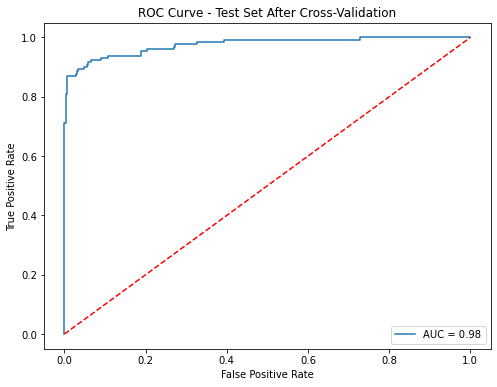

In [51]:
# Compute ROC curve and ROC area for test set
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = roc_auc_score(y_test, y_test_proba)

# Plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1], [0,1], 'r--')
plt.title('ROC Curve - Test Set After Cross-Validation')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


In [84]:
# Encoding is already done

In [85]:
# Token Visualisation

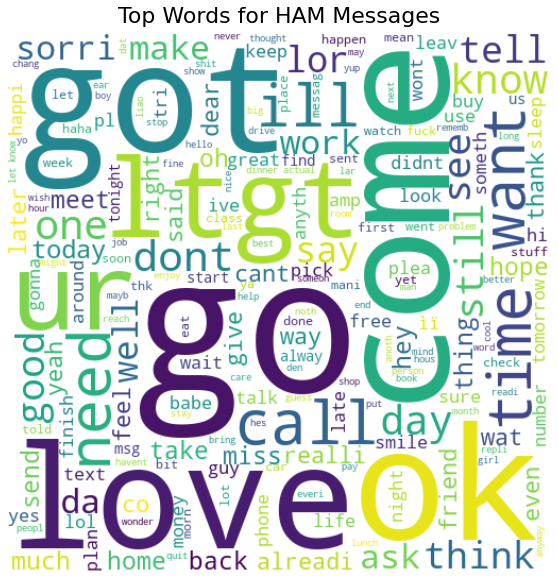

In [89]:
twitter_mask = np.array(Image.open('twitter_mask3.png'))

# Create the word cloud object
wc = WordCloud(
    background_color='white', 
    max_words=200, 
    mask=twitter_mask,
)

# Generate the word cloud for 'ham' messages (target == 0)
wc.generate(' '.join(text for text in df.loc[df['target'] == 0, 'message_clean']))

# Display the word cloud
plt.figure(figsize=(18,10))
plt.title('Top Words for HAM Messages', 
          fontdict={'size': 22, 'verticalalignment': 'bottom'})
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

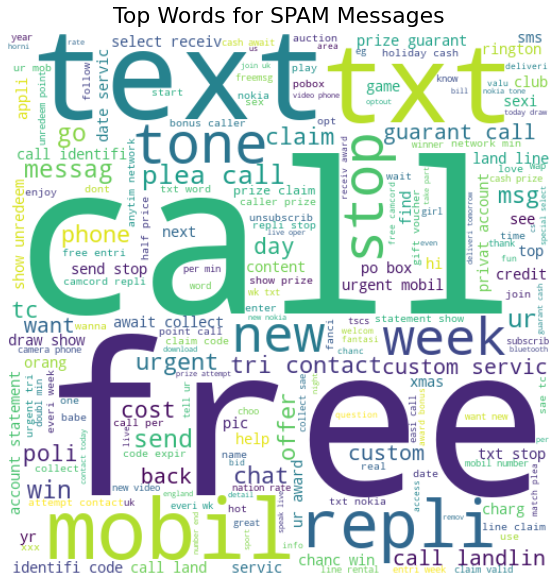

In [90]:
# Generate word cloud for 'spam' messages (target == 1)
wc.generate(' '.join(text for text in df.loc[df['target'] == 1, 'message_clean']))

# Display the word cloud for 'spam' messages
plt.figure(figsize=(18,10))
plt.title('Top Words for SPAM Messages', 
          fontdict={'size': 22, 'verticalalignment': 'bottom'})
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [93]:
# Split into train and test sets
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

3876 3876
1293 1293


In [95]:
from sklearn.feature_extraction.text import CountVectorizer

# instantiate the vectorizer
vect = CountVectorizer()
vect.fit(x_train)

CountVectorizer()

In [96]:
# Use the trained to create a document-term matrix from train and test sets
x_train_dtm = vect.transform(x_train)
x_test_dtm = vect.transform(x_test)

In [97]:
vect_tunned = CountVectorizer(stop_words='english', ngram_range=(1,2), min_df=0.1, max_df=0.7, max_features=100)

In [98]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()

tfidf_transformer.fit(x_train_dtm)
x_train_tfidf = tfidf_transformer.transform(x_train_dtm)

x_train_tfidf

<3876x5664 sparse matrix of type '<class 'numpy.float64'>'
	with 29780 stored elements in Compressed Sparse Row format>

In [101]:
# Word Embeddings (Glove)

In [109]:
texts = df['message_clean']
target = df['target']

In [108]:
df.head()

target                                            message  message_ln  \
0       0  Go until jurong point, crazy.. Available only ...          20   
1       0                      Ok lar... Joking wif u oni...           6   
2       1  Free entry in 2 a wkly comp to win FA Cup fina...          28   
3       0  U dun say so early hor... U c already then say...          11   
4       0  Nah I don't think he goes to usf, he lives aro...          13   

   num_chars  num_words                                      message_clean  
0        111         20  go jurong point crazi avail bugi n great world...  
1         29          6                                ok lar joke wif oni  
2        155         28  free entri  wkli comp win fa cup final tkts  m...  
3         49         11                        dun say ear hor alreadi say  
4         61         13          nah dont think goe usf live around though

In [112]:
# Calculate the length of our vocabulary
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(texts)

vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

6726

In [124]:
sequences = word_tokenizer.texts_to_sequences(texts)
tf.keras.preprocessing.sequence.pad_sequences(
    sequences, maxlen=None, dtype='int32', padding='pre',
    truncating='pre', value=0.0
)

array([[   0,    0,    0, ...,   14, 2886,   65],
       [   0,    0,    0, ...,  543,  314, 1374],
       [   0,    0,    0, ...,   36, 2888,  303],
       ...,
       [   0,    0,    0, ..., 1353, 6725, 1226],
       [   0,    0,    0, ...,  732,  137,   10],
       [   0,    0,    0, ..., 1832,  417,  181]])

In [127]:
def embed(corpus): 
    return word_tokenizer.texts_to_sequences(corpus)

longest_train = max(texts, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))

train_padded_sentences = pad_sequences(
    embed(texts), 
    length_long_sentence, 
    padding='post'
)

train_padded_sentences

array([[   2, 2885,  261, ...,    0,    0,    0],
       [   8,  219,  543, ...,    0,    0,    0],
       [  10,  394,  770, ...,    0,    0,    0],
       ...,
       [6724, 1353, 6725, ...,    0,    0,    0],
       [ 134, 1162, 1489, ...,    0,    0,    0],
       [1832,  417,  181, ...,    0,    0,    0]])

In [128]:
# GLOVE

In [132]:
embeddings_dictionary = dict()
embedding_dim = 100

# Load GloVe 100D embeddings with UTF-8 encoding
with open('glove.6B.100d.txt', encoding='utf-8') as fp:
    for line in fp:
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary[word] = vector_dimensions

print(f"Loaded {len(embeddings_dictionary)} word vectors.")

Loaded 400000 word vectors.


In [133]:
# Now we will load embedding vectors of those words that appear in the
# Glove dictionary. Others will be initialized to 0.

embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
        
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.57832998, -0.0036551 ,  0.34658   , ...,  0.070204  ,
         0.44509   ,  0.24147999],
       [-0.078894  ,  0.46160001,  0.57779002, ...,  0.26352   ,
         0.59397   ,  0.26741001],
       ...,
       [ 0.63009   , -0.036992  ,  0.24052   , ...,  0.10029   ,
         0.056822  ,  0.25018999],
       [-0.12002   , -1.23870003, -0.23303001, ...,  0.13658001,
        -0.61848003,  0.049843  ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [134]:
# MODELLING

In [135]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Train a Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.99      0.98      0.98       884
           1       0.98      0.99      0.98       923

    accuracy                           0.98      1807
   macro avg       0.98      0.98      0.98      1807
weighted avg       0.98      0.98      0.98      1807



In [136]:
import plotly.figure_factory as ff

x_axes = ['Ham', 'Spam']
y_axes =  ['Spam', 'Ham']

def conf_matrix(z, x=x_axes, y=y_axes):
    
    z = np.flip(z, 0)

    # change each element of z to type string for annotations
    z_text = [[str(y) for y in x] for x in z]

    # set up figure 
    fig = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_text, colorscale='Viridis')

    # add title
    fig.update_layout(title_text='<b>Confusion matrix</b>',
                      xaxis = dict(title='Predicted value'),
                      yaxis = dict(title='Real value')
                     )

    # add colorbar
    fig['data'][0]['showscale'] = True
    
    return fig

In [142]:
from sklearn.naive_bayes import MultinomialNB

# Create the Multinomial Naive Bayes model
nb = MultinomialNB()

# Train the model
nb.fit(X_resampled, y_resampled)


MultinomialNB()